In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of samples
k_max = 10000
t = np.linspace(0, k_max, k_max)  # Time variable

# Generate random inputs
u = 2 * np.random.uniform(-5, 5, k_max)

# Initialize y(k) array
y = np.zeros(k_max)

# Define y(k) calculations
for k in range(1, k_max):
    y[k] = 1 / (1 + (y[k-1])**2) + 0.25 * u[k] - 0.3 * u[k-1]

# Shift arrays for y(k-1), y(k-2), u(k-1), u(k-2)
y_k_1 = np.zeros(k_max)
y_k_2 = np.zeros(k_max)
u_k_1 = np.zeros(k_max)
u_k_2 = np.zeros(k_max)

y_k_1[1:] = y[:-1]
y_k_2[2:] = y[:-2]
u_k_1[1:] = u[:-1]
u_k_2[2:] = u[:-2]

In [7]:
t.shape, u.shape, y.shape, y_k_1.shape, y_k_2.shape, u_k_1.shape, u_k_2.shape

((10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,))

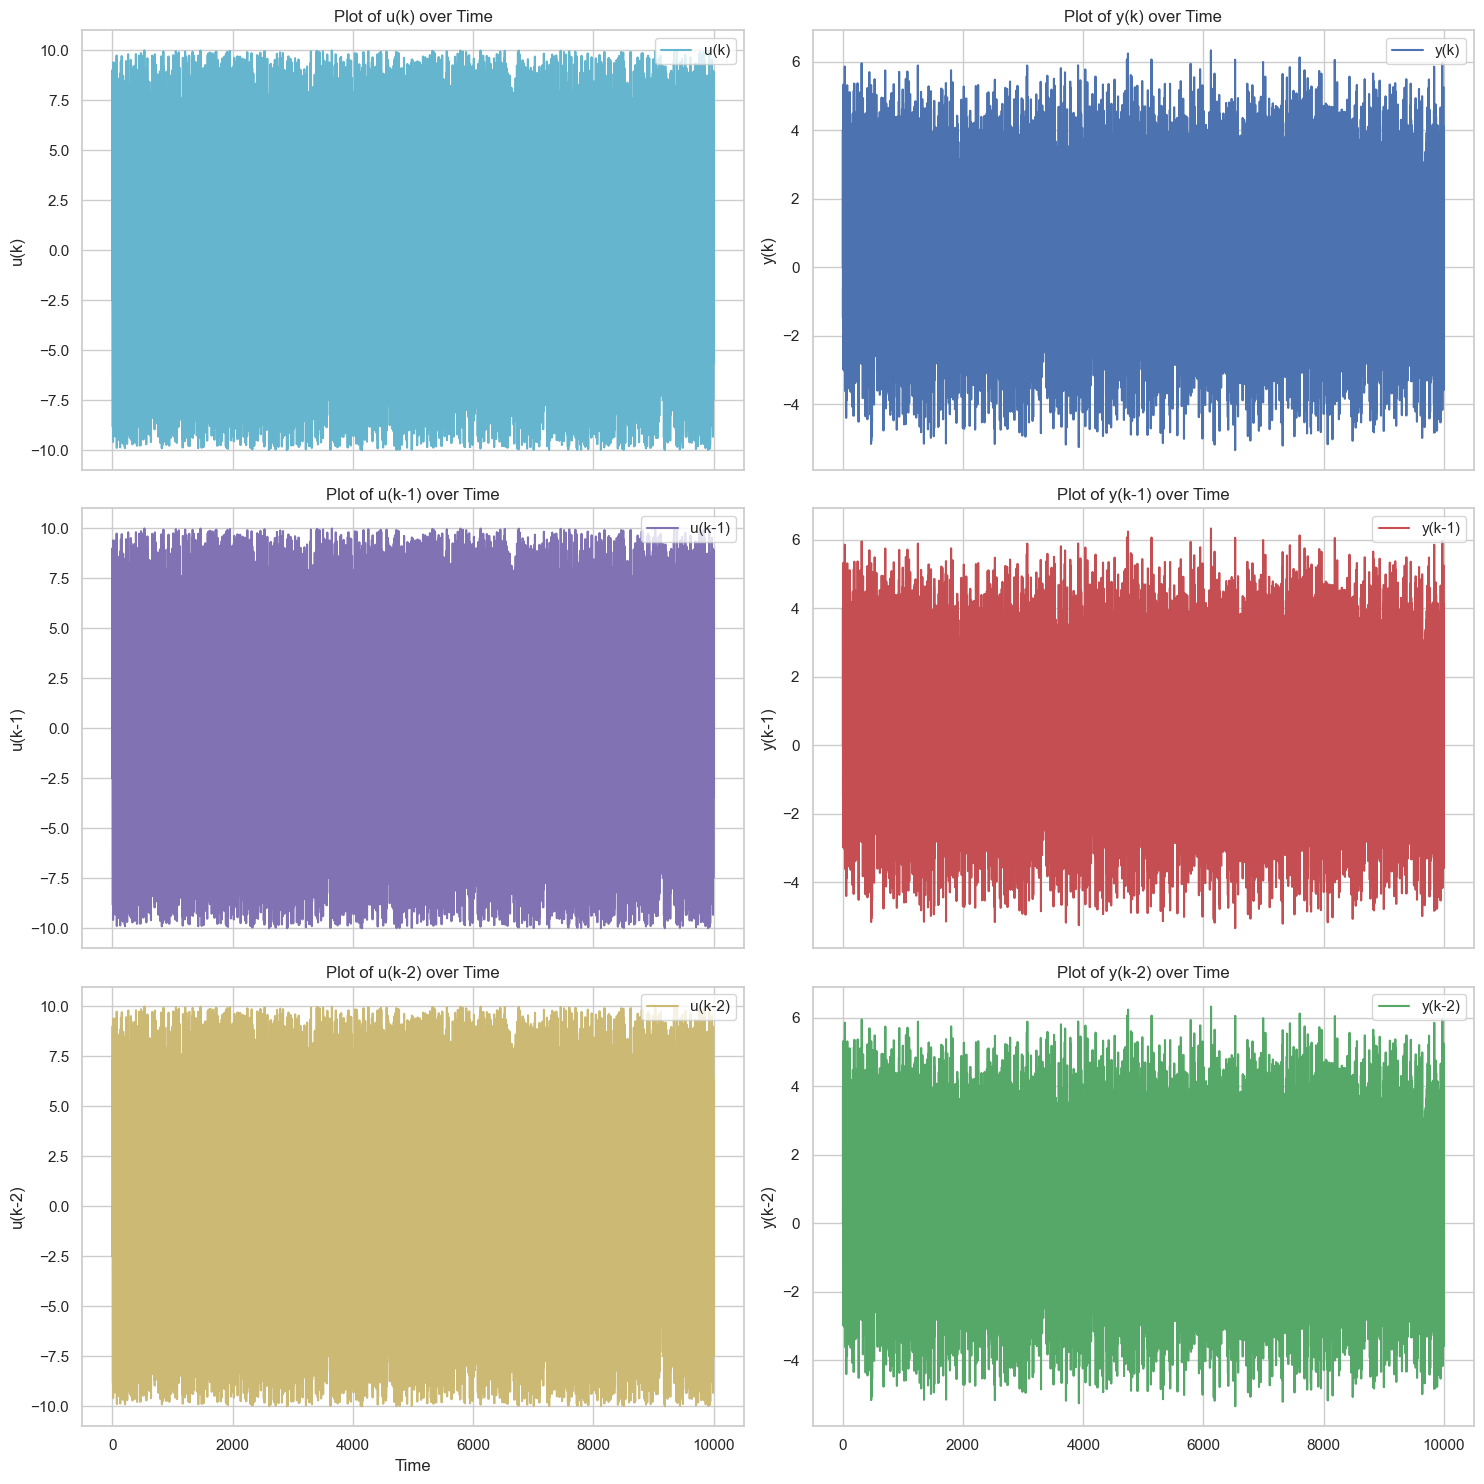

In [8]:
# Set up Seaborn style
sns.set_theme(style="whitegrid")

# Create a single figure with a 3x2 grid of subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 15), sharex=True)

# Plot u(k) over time
ax[0, 0].plot(t, u, label='u(k)', color='c')
ax[0, 0].set_ylabel('u(k)')
ax[0, 0].set_title('Plot of u(k) over Time')
ax[0, 0].legend()
ax[0, 0].grid(True)

# Plot y(k) over time
ax[0, 1].plot(t, y, label='y(k)', color='b')
ax[0, 1].set_ylabel('y(k)')
ax[0, 1].set_title('Plot of y(k) over Time')
ax[0, 1].legend()
ax[0, 1].grid(True)

# Plot u(k-1) over time
ax[1, 0].plot(t, u_k_1, label='u(k-1)', color='m')
ax[1, 0].set_ylabel('u(k-1)')
ax[1, 0].set_title('Plot of u(k-1) over Time')
ax[1, 0].legend()
ax[1, 0].grid(True)

# Plot y(k-1) over time
ax[1, 1].plot(t, y_k_1, label='y(k-1)', color='r')
ax[1, 1].set_ylabel('y(k-1)')
ax[1, 1].set_title('Plot of y(k-1) over Time')
ax[1, 1].legend()
ax[1, 1].grid(True)

# Plot u(k-2) over time
ax[2, 0].plot(t, u_k_2, label='u(k-2)', color='y')
ax[2, 0].set_xlabel('Time')
ax[2, 0].set_ylabel('u(k-2)')
ax[2, 0].set_title('Plot of u(k-2) over Time')
ax[2, 0].legend()
ax[2, 0].grid(True)

# Plot y(k-2) over time
ax[2, 1].plot(t, y_k_2, label='y(k-2)', color='g')
ax[2, 1].set_ylabel('y(k-2)')
ax[2, 1].set_title('Plot of y(k-2) over Time')
ax[2, 1].legend()
ax[2, 1].grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()

In [9]:
X = np.column_stack((u, u_k_1, u_k_2, y_k_1, y_k_2))
y = y.reshape(-1, 1)
u = u.reshape(-1, 1)
u_k_1 = u_k_1.reshape(-1, 1)
u_k_2 = u_k_2.reshape(-1, 1)
y_k_1 = y_k_1.reshape(-1, 1)
y_k_2 = y_k_2.reshape(-1, 1)

In [10]:
input_scaler = MinMaxScaler(feature_range=(-1, 1))
input_scaler.fit(u.reshape(-1, 1))
output_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler.fit(y.reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [11]:
u_norm = input_scaler.transform(u.reshape(-1, 1)).flatten()
y_norm = output_scaler.transform(y.reshape(-1, 1)).flatten()
u_k_1_norm = input_scaler.transform(u_k_1.reshape(-1, 1)).flatten()
u_k_2_norm = input_scaler.transform(u_k_2.reshape(-1, 1)).flatten()
y_k_1_norm = output_scaler.transform(y_k_1.reshape(-1, 1)).flatten()
y_k_2_norm = output_scaler.transform(y_k_2.reshape(-1, 1)).flatten()

In [12]:
# Define the arrays for each variable
X_norm = np.column_stack((y_norm, y_k_1_norm, y_k_2_norm, u_k_1_norm, u_k_2_norm))
u_norm = u_norm.reshape(-1, 1)
y_norm = y_norm.reshape(-1, 1)
u_k_1_norm = u_k_1_norm.reshape(-1, 1)
u_k_2_norm = u_k_2_norm.reshape(-1, 1)
y_k_1_norm = y_k_1_norm.reshape(-1, 1)
y_k_2_norm = y_k_2_norm.reshape(-1, 1)

In [13]:
X.shape, y.shape, u.shape, u_k_1.shape, u_k_2.shape, y_k_1.shape, y_k_2.shape

((10000, 5),
 (10000, 1),
 (10000, 1),
 (10000, 1),
 (10000, 1),
 (10000, 1),
 (10000, 1))

In [14]:
X_df = pd.DataFrame(X, columns=['y', 'y(k-1)', 'y(k-2)', 'u(k-1)', 'u(k-2)'])
u_df = pd.DataFrame(y, columns=['u'])
X_norm_df = pd.DataFrame(X_norm, columns=['y', 'y(k-1)', 'y(k-2)', 'u(k-1)', 'u(k-2)'])
u_norm_df = pd.DataFrame(u_norm, columns=['u'])
df = pd.concat([X_df, u_df], axis=1)
norm_df = pd.concat([X_norm_df, u_norm_df], axis=1)

In [15]:
df.describe()

y        y(k-1)        y(k-2)        u(k-1)        u(k-2)  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.116809     -0.116243     -0.116038      0.383105      0.383365   
std        5.752603      5.752336      5.752303      2.299250      2.299059   
min       -9.999767     -9.999767     -9.999767     -5.340716     -5.340716   
25%       -5.073423     -5.072228     -5.072228     -1.265325     -1.264097   
50%       -0.149428     -0.148955     -0.148128      0.392119      0.392119   
75%        4.800127      4.800127      4.800127      2.051329      2.051329   
max        9.994353      9.994353      9.994353      6.324696      6.324696   

                  u  
count  10000.000000  
mean       0.383038  
std        2.299271  
min       -5.340716  
25%       -1.265325  
50%        0.392119  
75%        2.051329  
max        6.324696

In [16]:
norm_df.describe()

y        y(k-1)        y(k-2)        u(k-1)        u(k-2)  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.018680     -0.018668     -0.018623     -0.011357     -0.011336   
std        0.394203      0.394200      0.394167      0.575403      0.575399   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.301286     -0.301286     -0.301076     -0.507101     -0.507101   
50%       -0.017123     -0.017123     -0.017123     -0.014629     -0.014546   
75%        0.267344      0.267344      0.267344      0.480425      0.480425   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  u  
count  10000.000000  
mean      -0.011414  
std        0.575429  
min       -1.000000  
25%       -0.507221  
50%       -0.014676  
75%        0.480425  
max        1.000000

In [17]:
# Calculate the split index
split_index = int(0.8 * len(X_norm))

# Split the data
X_norm_train = X_norm[:split_index]
X_norm_val = X_norm[split_index:]
u_norm_train = u_norm[:split_index]
u_norm_val = u_norm[split_index:]

In [18]:
X_norm_train.shape, X_norm_val.shape, u_norm_train.shape, u_norm_val.shape

((8000, 5), (2000, 5), (8000, 1), (2000, 1))

In [19]:
# Define the model architecture
model = Sequential([
    Dense(64, activation='tanh', input_shape=(X_norm_train.shape[1],)),
    Dense(32, activation='tanh'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# Define the path and filename for the best model
checkpoint_filepath = 'control_tahap1.h5'  # You can choose a different path or filename

# Initialize the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',             # Metric to monitor
    verbose=1,                      # Verbosity mode
    save_best_only=True,            # Save only the best model
    save_weights_only=False,        # Set to True to save only weights
    mode='min',                     # 'min' because we want to minimize loss
    save_freq='epoch'               # Save at the end of each epoch
)

# (Optional) Initialize EarlyStopping callback
# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=50,                    # Number of epochs with no improvement after which training will be stopped
#     verbose=1,
#     restore_best_weights=True       # Restore model weights from the epoch with the best value of the monitored quantity
# )

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Calculate the full batch size
full_batch_size = X_norm_train.shape[0]

# Train the model
history = model.fit(
    X_norm_train,
    u_norm_train,
    epochs=10000,                         # You can adjust the number of epochs
    batch_size=full_batch_size,           # Typically, you might use smaller batch sizes
    validation_data=(X_norm_val, u_norm_val),
    verbose=1,
    callbacks=[checkpoint_callback]  # Add callbacks here
)

Epoch 1/10000
1/1 [==============================] - ETA: 0s - loss: 0.6079 - mean_absolute_error: 0.6375
Epoch 1: val_loss improved from inf to 0.51372, saving model to control_tahap1.h5
1/1 [==============================] - 2s 2s/step - loss: 0.6079 - mean_absolute_error: 0.6375 - val_loss: 0.5137 - val_mean_absolute_error: 0.5856
Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: 0.5432 - mean_absolute_error: 0.6022
Epoch 2: val_loss improved from 0.51372 to 0.45908, saving model to control_tahap1.h5
1/1 [==============================] - 0s 45ms/step - loss: 0.5432 - mean_absolute_error: 0.6022 - val_loss: 0.4591 - val_mean_absolute_error: 0.5539
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: 0.4856 - mean_absolute_error: 0.5693
Epoch 3: val_loss improved from 0.45908 to 0.41097, saving model to control_tahap1.h5
1/1 [==============================] - 0s 46ms/step - loss: 0.4856 - mean_absolute_error: 0.5693 - val_loss: 0.4110 - val_mean_abs

In [21]:
model.save('control_tahap1.h5')

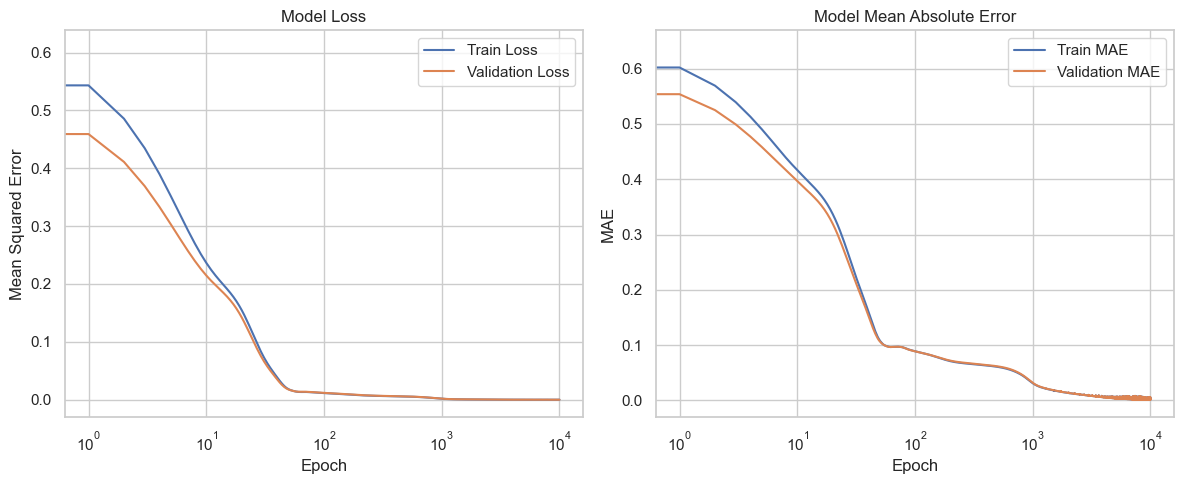

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title('Model Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
u_norm_pred = model.predict(X_norm)
u_pred = input_scaler.inverse_transform(u_norm_pred)

94/94 [==============================] - 0s 2ms/step


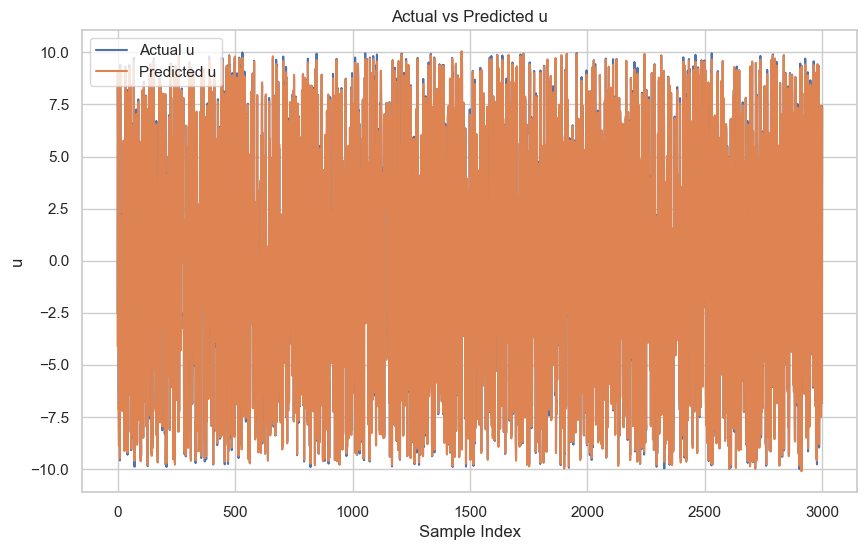

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(u, label='Actual u')
plt.plot(u_pred, label='Predicted u')
plt.title('Actual vs Predicted u')
plt.xlabel('Sample Index')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Generate a sine wave input
sine_wave_length = 3000
sine_wave_t = np.linspace(0, 2 * np.pi, sine_wave_length)
sine_wave_u = 10 * np.sin(10 * sine_wave_t)

# Initialize y(k) array for sine wave
sine_wave_y = np.zeros(sine_wave_length)

# Shift arrays for y(k-1), y(k-2), u(k-1), u(k-2)
sine_wave_y_k_1 = np.zeros(sine_wave_length)
sine_wave_y_k_2 = np.zeros(sine_wave_length)
sine_wave_u_k_1 = np.zeros(sine_wave_length)
sine_wave_u_k_2 = np.zeros(sine_wave_length)

for k in range(1, k_max):
    sine_wave_y[k] = 1 / (1 + (sine_wave_y[k-1])**2) + 0.25 * sine_wave_u[k] - 0.3 * sine_wave_u[k-1]

sine_wave_y_k_1[1:] = sine_wave_y[:-1]
sine_wave_y_k_2[2:] = sine_wave_y[:-2]
sine_wave_u_k_1[1:] = sine_wave_u[:-1]
sine_wave_u_k_2[2:] = sine_wave_u[:-2]

# Normalize the sine wave input
sine_wave_y_norm = output_scaler.transform(sine_wave_y.reshape(-1, 1)).flatten()
sine_wave_u_k_1_norm = input_scaler.transform(sine_wave_u_k_1.reshape(-1, 1)).flatten()
sine_wave_u_k_2_norm = input_scaler.transform(sine_wave_u_k_2.reshape(-1, 1)).flatten()
sine_wave_y_k_1_norm = output_scaler.transform(sine_wave_y_k_1.reshape(-1, 1)).flatten()
sine_wave_y_k_2_norm = output_scaler.transform(sine_wave_y_k_2.reshape(-1, 1)).flatten()

# Define the arrays for each variable
sine_wave_X_norm = np.column_stack((sine_wave_y_norm, sine_wave_y_k_1_norm, sine_wave_y_k_2_norm, sine_wave_u_k_1_norm, sine_wave_u_k_2_norm))

In [22]:
# Predict the output using the trained model
sine_wave_u_norm_pred = model.predict(sine_wave_X_norm)
sine_wave_u_pred = input_scaler.inverse_transform(sine_wave_u_norm_pred)

94/94 [==============================] - 0s 3ms/step


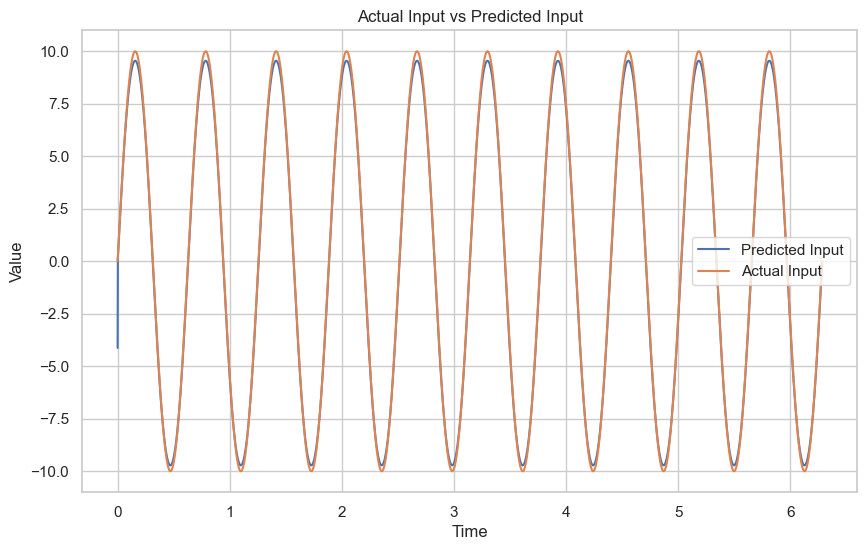

In [23]:
# Plot the actual sine wave input and the predicted output
plt.figure(figsize=(10, 6))
# plt.plot(sine_wave_t, sine_wave_u, label='Sine Wave Input')
plt.plot(sine_wave_t, sine_wave_u_pred, label='Predicted Input')
plt.plot(sine_wave_t, sine_wave_u, label='Actual Input')
plt.title('Actual Input vs Predicted Input')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
model = load_model('control_tahap1.h5')

In [26]:
import copy

# Number of training samples
num_train = X_norm_train.shape[0]

# Initialize previous predictions (in normalized scale)
u_pred_prev1 = 0.0  # y_pred(k-1)
u_pred_prev2 = 0.0  # y_pred(k-2)

# Prepare a copy of training data to manipulate
X_train_feedback = X_norm_train.copy()
u_train_feedback = u_norm_train.copy()

# Replace the y(k-1) and y(k-2) in training data with initial zeros
X_train_feedback[:, 3] = 0.0  # y(k-1)
X_train_feedback[:, 4] = 0.0  # y(k-2)

# Initialize lists to store training metrics
train_loss_list = []
train_mae_list = []

# Initialize lists to store validation metrics
val_loss_list = []
val_mae_list = []

# Initialize variables to track the best model
best_loss = np.inf
best_weights = None  # To store the best weights

# Training with feedback
for k in range(num_train):
    # Get current input features
    y_k = X_train_feedback[k, 0]
    y_k_1 = X_train_feedback[k, 1]
    y_k_2 = X_train_feedback[k, 2]
    
    # Current y(k-1) and y(k-2) from feedback
    u_k_1_pred = u_pred_prev1
    u_k_2_pred = u_pred_prev2
    
    # Construct the input vector for the current sample
    input_vector = np.array([y_k, y_k_1, y_k_2, u_k_1_pred, u_k_2_pred]).reshape(1, -1).astype(np.float32)
    
    # Get the true target
    u_true = u_train_feedback[k].reshape(1, -1)
    
    # Perform a single gradient update (train_on_batch)
    loss, mae = model.train_on_batch(input_vector, u_true)
    
    # Append the loss and mae to the training lists
    train_loss_list.append(loss)
    train_mae_list.append(mae)

    # Check if current loss is the best
    if loss < best_loss:
        best_loss = loss
        best_weights = copy.deepcopy(model.get_weights())
        # If saving to disk, uncomment the following line:
        model.save('control_tahap2.h5')
    
    # Make a prediction with the current input
    u_pred = model.predict(input_vector, verbose=0)
    
    # Update previous predictions for feedback
    u_pred_prev2 = u_pred_prev1
    u_pred_prev1 = u_pred.flatten()[0]
    
    # Optionally, monitor progress
    if (k+1) % 1 == 0:
        print(f"Processed {k+1}/{num_train} samples. Current Loss: {loss:.6f}, MAE: {mae:.6f}")

Processed 1/2400 samples. Current Loss: 0.255645, MAE: 0.505613
Processed 2/2400 samples. Current Loss: 1.598006, MAE: 1.264122
Processed 3/2400 samples. Current Loss: 0.135941, MAE: 0.368702
Processed 4/2400 samples. Current Loss: 0.180273, MAE: 0.424586
Processed 5/2400 samples. Current Loss: 0.193467, MAE: 0.439849
Processed 6/2400 samples. Current Loss: 0.020835, MAE: 0.144344
Processed 7/2400 samples. Current Loss: 1.639859, MAE: 1.280570
Processed 8/2400 samples. Current Loss: 0.055930, MAE: 0.236496
Processed 9/2400 samples. Current Loss: 0.070305, MAE: 0.265150
Processed 10/2400 samples. Current Loss: 0.436336, MAE: 0.660557
Processed 11/2400 samples. Current Loss: 0.048021, MAE: 0.219138
Processed 12/2400 samples. Current Loss: 0.554496, MAE: 0.744645
Processed 13/2400 samples. Current Loss: 0.164562, MAE: 0.405663
Processed 14/2400 samples. Current Loss: 0.042152, MAE: 0.205309
Processed 15/2400 samples. Current Loss: 0.006626, MAE: 0.081402
Processed 16/2400 samples. Current

In [27]:
model.set_weights(best_weights)

In [28]:
# Number of validation samples
num_val = X_norm_val.shape[0]

# Initialize previous predictions for validation
u_val_prev1 = 0.0
u_val_prev2 = 0.0

# Initialize lists to store true and predicted values for plotting
u_val_true_list = []
u_val_pred_list = []

for k in range(num_val):
    # Get current input features
    y_k = X_norm_val[k, 0]
    y_k_1 = X_norm_val[k, 1]
    y_k_2 = X_norm_val[k, 2]
    
    # Current y(k-1) and y(k-2) from feedback
    u_k_1_pred = u_val_prev1
    u_k_2_pred = u_val_prev2
    
    # Construct the input vector for the current sample
    input_vector = np.array([y_k, y_k_1, y_k_2, u_k_1_pred, u_k_2_pred]).reshape(1, -1).astype(np.float32)
    
    # Get the true target
    u_true = u_norm_val[k].reshape(1, -1)
    u_val_true_list.append(u_true.flatten()[0])
    
    # Make a prediction with the current input
    u_pred = model.predict(input_vector, verbose=0)
    u_val_pred_list.append(u_pred.flatten()[0])
    
    # Calculate loss and MAE manually
    loss = np.mean((u_true - u_pred) ** 2)
    mae = np.mean(np.abs(u_true - u_pred))
    val_loss_list.append(loss)
    val_mae_list.append(mae)
    
    # Update previous predictions for feedback
    u_val_prev2 = u_val_prev1
    u_val_prev1 = u_pred.flatten()[0]
    
    # Optionally, monitor progress
    if (k+1) % 1 == 0:
        print(f"Processed {k+1}/{num_val} validation samples. Current Loss: {loss:.6f}, MAE: {mae:.6f}")

# Calculate validation loss and MAE
u_val_true_array = np.array(u_val_true_list).reshape(-1, 1)
u_val_pred_array = np.array(u_val_pred_list).reshape(-1, 1)

# Compute MSE and MAE manually
mse = np.mean((u_val_true_array - u_val_pred_array) ** 2)
mae = np.mean(np.abs(u_val_true_array - u_val_pred_array))

print(f"Overall Validation Loss (MSE): {mse:.6f}")
print(f"Overall Validation MAE: {mae:.6f}")

Processed 1/600 validation samples. Current Loss: 0.020816, MAE: 0.144278
Processed 2/600 validation samples. Current Loss: 0.128498, MAE: 0.358467
Processed 3/600 validation samples. Current Loss: 0.120268, MAE: 0.346797
Processed 4/600 validation samples. Current Loss: 0.140089, MAE: 0.374284
Processed 5/600 validation samples. Current Loss: 0.022386, MAE: 0.149621
Processed 6/600 validation samples. Current Loss: 0.007834, MAE: 0.088508
Processed 7/600 validation samples. Current Loss: 0.035933, MAE: 0.189560
Processed 8/600 validation samples. Current Loss: 0.063343, MAE: 0.251681
Processed 9/600 validation samples. Current Loss: 0.131080, MAE: 0.362049
Processed 10/600 validation samples. Current Loss: 0.013767, MAE: 0.117331
Processed 11/600 validation samples. Current Loss: 0.081086, MAE: 0.284757
Processed 12/600 validation samples. Current Loss: 0.006248, MAE: 0.079047
Processed 13/600 validation samples. Current Loss: 0.003532, MAE: 0.059427
Processed 14/600 validation sample

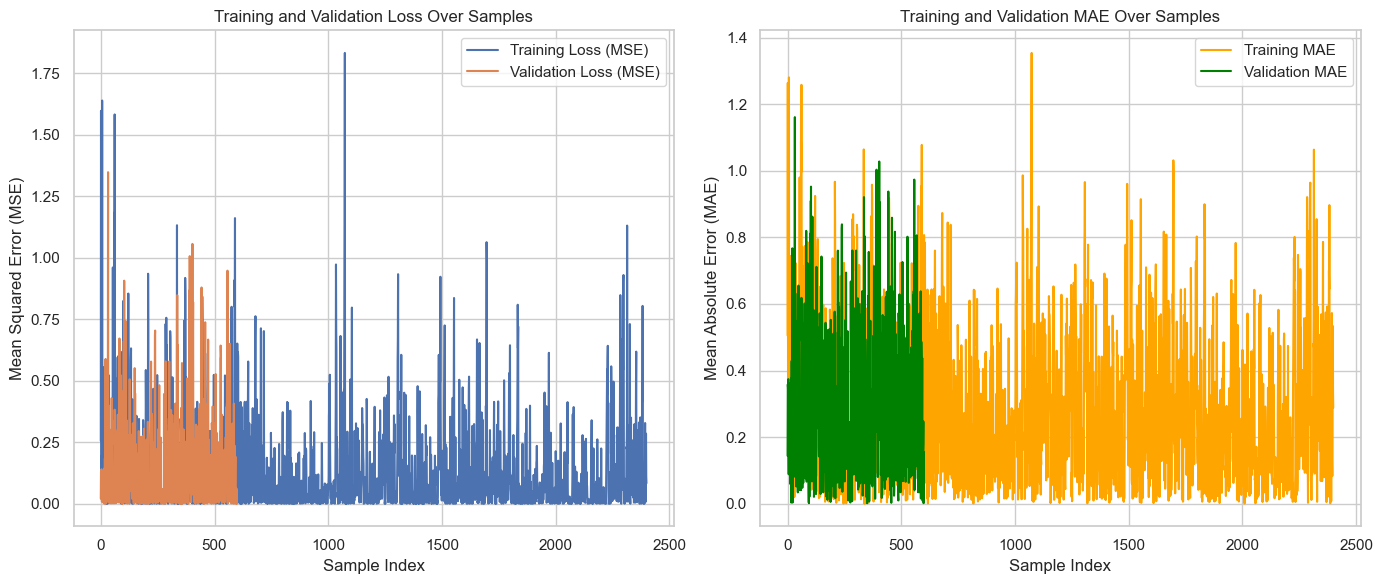

In [29]:
# Plot Training and Validation Loss
plt.figure(figsize=(14, 6))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss (MSE)')
plt.plot(val_loss_list, label='Validation Loss (MSE)')
plt.title('Training and Validation Loss Over Samples')
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)

# Subplot 2: MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_list, label='Training MAE', color='orange')
plt.plot(val_mae_list, label='Validation MAE', color='green')
plt.title('Training and Validation MAE Over Samples')
plt.xlabel('Sample Index')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [30]:
model.save('control_tahap2.h5')

In [31]:
model = load_model('control_tahap2.h5')

In [32]:
u_norm_pred_feedback = model.predict(X_norm)
u_pred_feedback = input_scaler.inverse_transform(u_norm_pred_feedback)

94/94 [==============================] - 0s 1ms/step


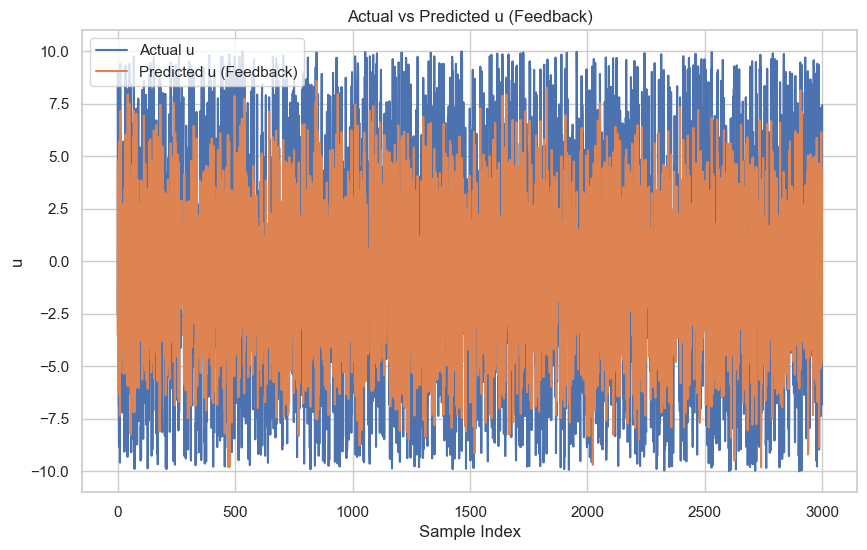

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(u, label='Actual u')
plt.plot(u_pred_feedback, label='Predicted u (Feedback)')
plt.title('Actual vs Predicted u (Feedback)')
plt.xlabel('Sample Index')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Predict the output using the trained model
sine_wave_u_norm_pred_feedback = model.predict(sine_wave_X_norm)
sine_wave_u_pred_feedback = input_scaler.inverse_transform(sine_wave_u_norm_pred_feedback)

94/94 [==============================] - 0s 1ms/step


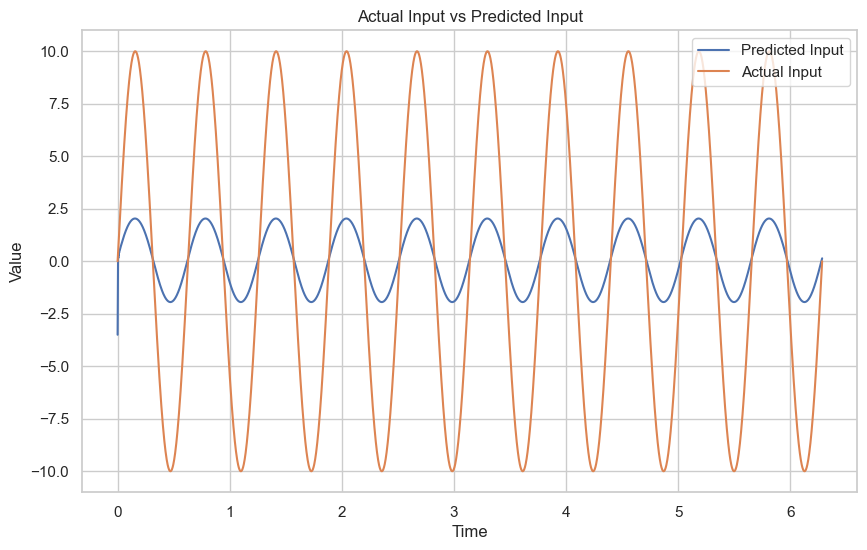

In [35]:
# Plot the actual sine wave input and the predicted output
plt.figure(figsize=(10, 6))
# plt.plot(sine_wave_t, sine_wave_u, label='Sine Wave Input')
plt.plot(sine_wave_t, sine_wave_u_pred_feedback, label='Predicted Input')
plt.plot(sine_wave_t, sine_wave_u, label='Actual Input')
plt.title('Actual Input vs Predicted Input')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
mse_random = np.mean((u - u_pred) ** 2)
mse_feedback_random = np.mean((u - u_pred_feedback) ** 2)
print(f"MSE without Feedback (Random Input): {mse_random:.6f}")
print(f"MSE with Feedback (Random Input): {mse_feedback_random:.6f}")

MSE without Feedback (Random Input): 34.362159
MSE with Feedback (Random Input): 10.570927


In [37]:
mse = np.mean((sine_wave_u - sine_wave_u_pred) ** 2)
mse_feedback = np.mean((sine_wave_u - sine_wave_u_pred_feedback) ** 2)
print(f"MSE without Feedback: {mse:.6f}")
print(f"MSE with Feedback: {mse_feedback:.6f}")

MSE without Feedback: 97.585275
MSE with Feedback: 51.997321
